# Classification of Rice types from Kaggle Rice Image Dataset using Deep Learning.

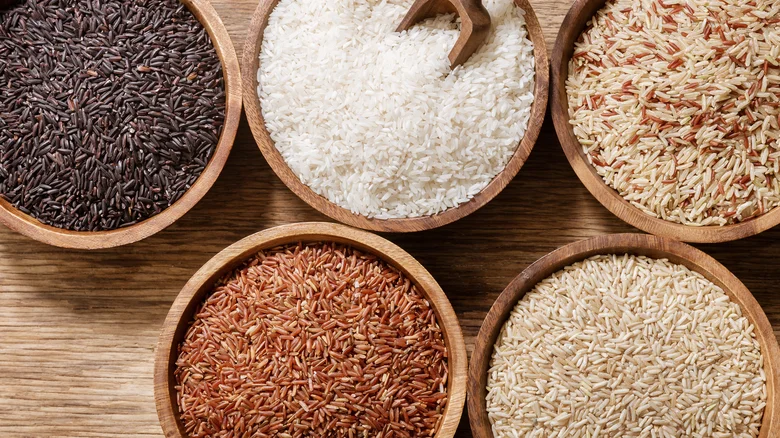

This is my course project for the course Jovian-Deep-learning zero-to-GANs.

The deep learning model has been trained using pytorch from scratch for classifying the types of rice from the various images of rice.

The rice image dataset has been has been taken from kaggle (https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset).

The model used for training is a Convolutional Neural Network (CNN).

### Contents
----------------------
1.  Installing and importing the required libraries.  
2.  Downloading the dataset from kaggle
3.  Importing the dataset using PyTorch
4.  Performing Data Augmentation
5.  Creating DataLoaders to retrieve batches of images.
6.  Moving everything to the GPU
7.  Creating a Base class with the required functions by extending it from the nn.module class
6.  Defining the Neural Network Architecture
7.  Creating and Training the model
8.  Plotting Accuracies and Loss against the no. of epochs.
9.  Testin the model with samples from the test dataset
10. Logging Hyperparameters on Jovian

## Setting up everything

Installing the Jovian python library and the opendatasets library. 

opendatasets is a Python library for downloading datasets from online sources like Kaggle and Google Drive using a simple Python command (https://github.com/JovianHQ/opendatasets)

In [ ]:
!pip install opendatasets --upgrade --quiet
!pip install jovian --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 KB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Importing all the necessary libraries
# import jovian
import opendatasets as od
import torchvision
import os
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

## Processing Data 

The Rice image dataset contains image data of different types of rice. The data is composed of 75000 images of size 250x250, which is distributed as 15000 images under 5 categories.

---------------------------------------------------

1. Ipsala
2. Arborio 
3. Karacadag
4. Basmati
5. Jasmine

### Downloading the dataset from Kaggle

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset'

# Dowloading the dataset from kaggle using the opendatasets library
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ashutoshdinesh
Your Kaggle Key: ··········


100%|██████████| 219M/219M [00:13<00:00, 16.4MB/s]


In [ ]:
# Setting the path to the directory where the images are located
data_dir = './rice-image-dataset/Rice_Image_Dataset'

In [ ]:
# Displaying all the classes of images as they are stored as separate directories under the Image Directory
os.listdir(data_dir)

['Arborio',
 'Karacadag',
 'Rice_Citation_Request.txt',
 'Ipsala',
 'Jasmine',
 'Basmati']

The Image directory contains an extra file, this has to be removed before loading the data

In [ ]:
os.remove(data_dir+'/Rice_Citation_Request.txt')

In [ ]:
# Displaying the total number of images under each Rice type 

for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

Arborio : 15000
Karacadag : 15000
Ipsala : 15000
Jasmine : 15000
Basmati : 15000


### Importing Dataset using Pytorch

I am using the `ImageFolder` class from `torchvision`


The `ImageFolder` Class creates a datasets of images and labels by converting the folder names of the images to the labels of the images 

Documentation link : https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [ ]:
# Creating the dataset using Imageloader
dataset = ImageFolder(data_dir)

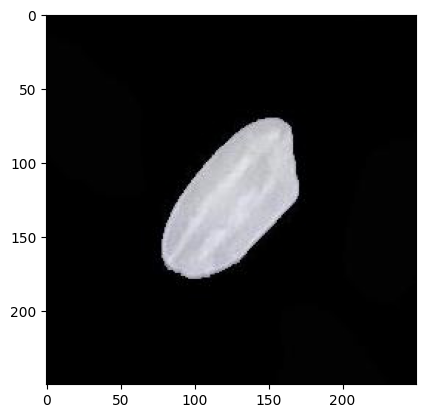

In [ ]:
# Trying to load a random sample from the dataset and viewing it
img, label = dataset[12345]
plt.imshow(img)

### Data Augmentation

-------------------------

Data augmentation is perfomed to increase the diversity of the dataset. In this case the image is resized, cropped and flipped horizontally at Random.

For achieving this, image transformations are applied using the torchvision.transforms library is used. The individual transforms are chained together using the compose function. 

Documentation link : https://pytorch.org/vision/stable/transforms.html


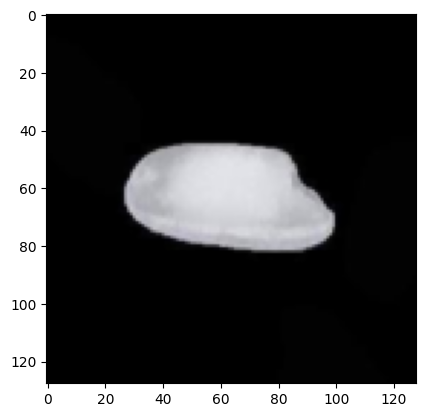

In [ ]:
# Transforming data to a tensor, reducing its size and cropping it
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(128), 
                                            tt.RandomCrop(128),
                                            tt.RandomHorizontalFlip(),
                                                          tt.ToTensor()]))

img, label = dataset[2316]
plt.imshow(img.permute((1, 2, 0)))

### Splitting the Dataset into Train, validation and Test Datasets

--------------------------------------------------

The dataset containing the 75000 images along with their labels are now split into training, validation and test datasets.

The validation dataset contains 20% of the images of the original dataset taken randomly. 

The test dataset contains 10% of the images of the original dataset taken randomly, which is not in the validation dataset. 

The rest of the data (images, labels) are used for training the model.

So the size of the training data is 52500,
the size of the validation data is 15000,
the size of the test data is 7500.


In [ ]:
val_pct = 0.2                                       # Percentage of dataset to be selected as Validation Data
test_pct = 0.1                                      # Percentage of dataset to be selected as Test Data

# Calculating the size of the Train, Test and Validation datasets
val_size = int(val_pct * len(dataset))              
test_size = int(test_pct * len(dataset))
train_size = len(dataset) - val_size - test_size

# Splitting the dataset randomly usin the random_plit function from the torch.utils.data library 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

print(len(train_ds), len(val_ds), len(test_ds))

52500 15000 7500


### Loading the Data 

---------------------------------------------

During model training, we want to pass data in minibatches, reshuffling them the data at every epoch to reduce overfitting and to speed up data retrieval. 

This is achieved by using the Dataloader. It is an iterable that can iterate through the dataset as needed. Each iteration returns a batch of images and labels of size 128. Because we specified shuffle=True for the train dataloader, after we iterate over all batches, the data is shuffled.


Documentation : https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
# Splitting the Data into batches for training 

batch_size = 128        

train_dl = DataLoader(train_ds, 
                          batch_size, 
                          shuffle=True, 
                          num_workers=4, 
                          pin_memory=True)

val_dl = DataLoader(val_ds, 
                        batch_size, 
                        num_workers=4, 
                        pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualising the data in one batch

---------------------------------------

The data from one batch is displayed in a grid structure

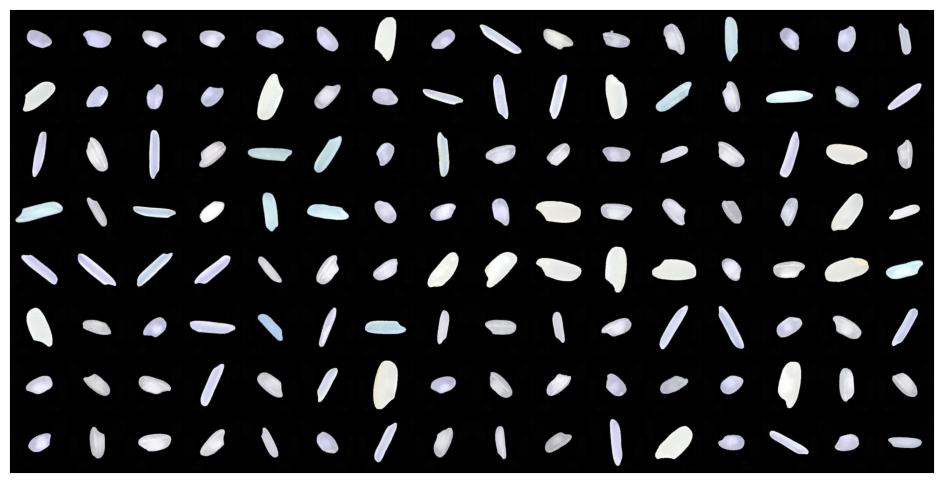

In [ ]:
# Visualising the images in one batch as a grid of images

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        plt.show()
        break


show_batch(train_dl)

## Moving to the GPU to make everything run faster
----------------------------------------------------

We are defining helper functions which will help move everything to the GPU to make it run faster

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Modeling

Creating a base class for our model. 

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

Using the base class to build our model. Here we are using a Convolutional Neural Network (CNN).


Read this article to know more about [CNN](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

![gif](https://miro.medium.com/v2/resize:fit:640/1*GcI7G-JLAQiEoCON7xFbhg.gif)



In [ ]:
#  Creating a CNN architecture and inheriting from the base class ImageClassificationBase

class RICECnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Input : 128 x 3 x 128 x 128
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # Output : 128 x 32 x 128 x 128
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Output : 128 x 64 x 128 x 128
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 128 x 64 x 64 x 64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Output : 128 x 128 x 64 x 64
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # Output : 128 x 256 x 64 x 64
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output : 128 x 256 x 32 x 32

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # Output : 128 x 512 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # Output : 128 x 512 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output : 128 x 512 x 16 x 16

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1), # Output : 128 x 1024 x 16 x 16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output : 128 x 1024 x 8 x 8

            nn.Flatten(),
            nn.Linear(1024 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = RICECnnModel()
model

RICECnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [ ]:
# Converting all Tensors and model to run on the specified device, in this case is CUDA
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(RICECnnModel(), device)

Passing one batch of input tensors to check if there are no errors in the architecture of the neural network 

In [ ]:
for batch in train_dl:
  images, labels = batch
  print('Shape',images.shape)
  print(images.device)
  preds = model(images)
  print('Preds.Shape',preds.shape)
  break

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Shape torch.Size([128, 3, 128, 128])
cuda:0
Preds.Shape torch.Size([128, 5])


## Training the Model

### Creating some fuctions for training the model

In [ ]:
# Function to Calculate the accuracy of the model
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):  # This Function evaluates the models performance and outputs the loss and accuracy
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Main Function of training the model
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history



Calculating the loss and accuracy of the vanilla model without training to create a baseline. 

In [ ]:
model = to_device(RICECnnModel(), device)

# Calculating the baseline of the model without training 
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[{'val_loss': 1.6095682382583618, 'val_acc': 0.20122703909873962}]

The baseline accuracy is around 20%, as we haven't yet trained the model

### Set Hyperparameters and Train
------------------------------------
Now we set the hyperparameters and start training.
We adjust the hyperparameters to gain maximum accuracy.

In [ ]:
#  Setting the hyperparameters before training
num_epochs = 5
opt_func = torch.optim.Adam  # Using ADAM optimizer 
lr = 0.001 # Learning Rate

# Training and displaying accuracy and loss
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.3624, val_loss: 0.1138, val_acc: 0.9606
Epoch [1], train_loss: 0.1048, val_loss: 0.0725, val_acc: 0.9742
Epoch [2], train_loss: 0.0846, val_loss: 0.0742, val_acc: 0.9742
Epoch [3], train_loss: 0.0554, val_loss: 0.0406, val_acc: 0.9885
Epoch [4], train_loss: 0.0426, val_loss: 0.0280, val_acc: 0.9904


In [ ]:
#  Setting the hyperparameters before training
num_epochs = 5
opt_func = torch.optim.SGD  # Using ADAM optimizer 
lr = 0.0001 # Learning Rate

# Training and displaying accuracy and loss
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 0.0247, val_loss: 0.0222, val_acc: 0.9921
Epoch [1], train_loss: 0.0225, val_loss: 0.0210, val_acc: 0.9933
Epoch [2], train_loss: 0.0216, val_loss: 0.0204, val_acc: 0.9929
Epoch [3], train_loss: 0.0205, val_loss: 0.0205, val_acc: 0.9930
Epoch [4], train_loss: 0.0204, val_loss: 0.0226, val_acc: 0.9922


### Plotting the accuracy and loss

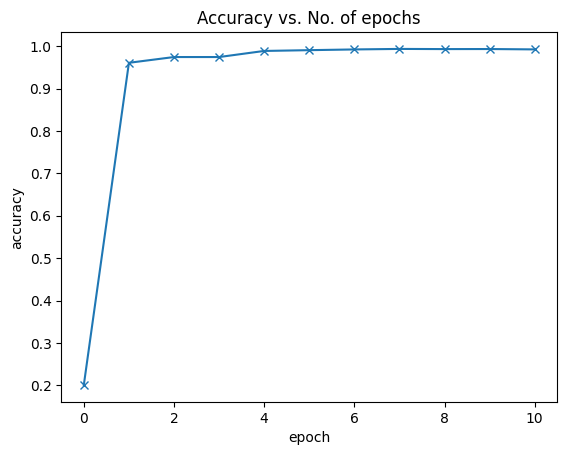

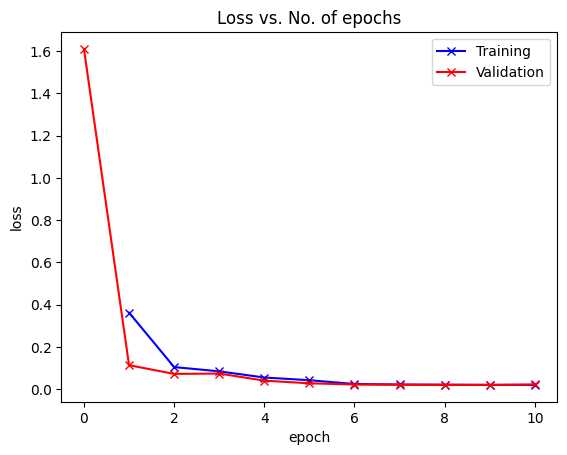

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()


plot_accuracies(history)
plot_losses(history)

## Prediction for the test dataset

Create a function to predict the label of an image

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Predict labels for 5 images and show the images as well

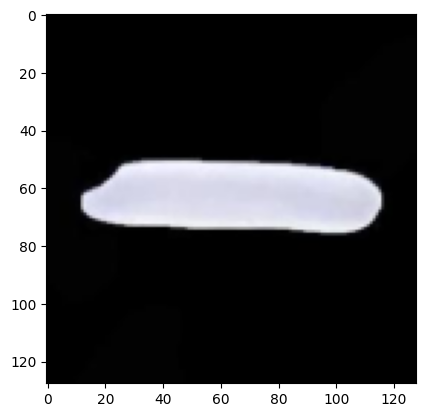

Label: Basmati , Predicted: Basmati


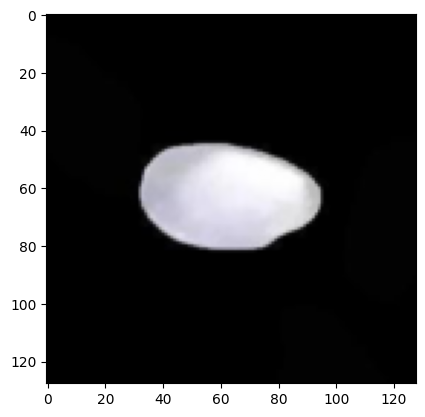

Label: Karacadag , Predicted: Karacadag


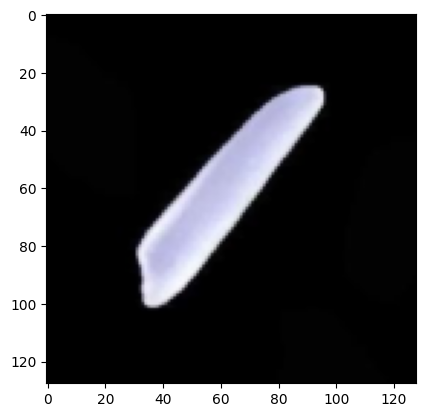

Label: Basmati , Predicted: Basmati


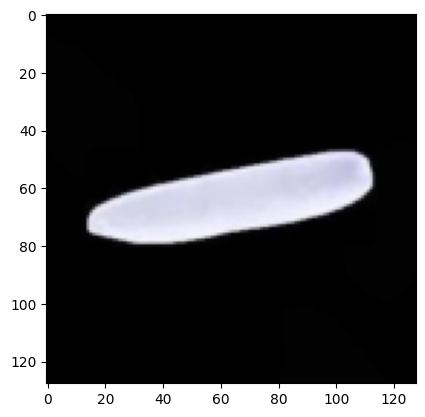

Label: Basmati , Predicted: Basmati


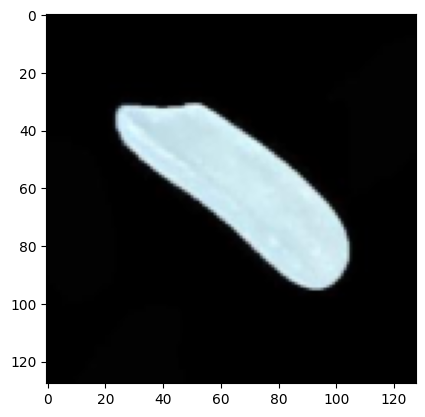

Label: Jasmine , Predicted: Jasmine


In [ ]:
import random

for i in range(0,5):
    data = random.choice(test_ds)
    img, label = data
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Evaluating the model on the test dataset

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
print(result)

{'val_loss': 0.024972999468445778, 'val_acc': 0.9916666746139526}


## Saving the model and Recording results 

In [ ]:
torch.save(model.state_dict(), './Rice-cnn.pth')

### Recording the results

In [ ]:
import jovian

jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128, 
                       epochs=5, 
                       arch='CNN', 
                       lrs=[0.001, 0.0001],
                       opt=['Adam','SGD'])
jovian.log_metrics(train_loss = history[-1]['train_loss'],
                   val_acc = history[-1]['val_acc'],
                   val_loss = history[-1]['val_loss']
                   )

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


## Conclusion

In this notebook, a deep learning model was designed and trained to successfully classify images of 5 types of Rice : Ipsala, Arborio, Karacadag, Basmati and Jasmine. 

## References

-----------------

1. https://jovian.com/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-4-image-classification-with-cnn

2. https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/

3. https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/